# Goal: studying U-Net by implementing it in End to end detection and segmentation of the nuclei in divergent images 

- Input: Taken only 30 samples of input images and corresponding output masks (very small input set) from 2018 Data Science Bowl (https://www.kaggle.com/c/data-science-bowl-2018/data) Data.
- note that single input sample/folder consists of multiple input images for them there will be multiple corresponding masks

### Package used:
- Keras is used for the implementation 
     - To see how to install Keras please refer this link: https://limitlessdatascience.wordpress.com/2019/07/28/installation-steps-for-3-important-deep-learning-packages/

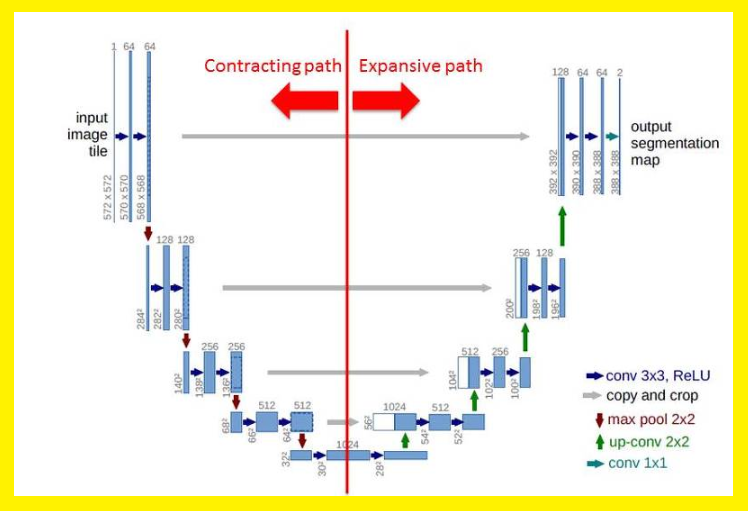

In [2]:
import PIL.Image as Image
Image.open("U Net Architecture.png") ## U - Net Architecture (Example) diagram

#### U-Net Architecture Consists of:
1. Downsampling path: a contracting path (left side)
2. Bottleneck 
3. Upsampling path: an expansive path (right side).

### Input data 2018 Data Science Bowl (https://www.kaggle.com/c/data-science-bowl-2018/data):
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence).
- Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders: 
    - images contain the image file.
    - masks contain the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).
    
Note: As with any human-annotated dataset, you may find various forms of errors in the data. You may manually correct errors you find in the training set. 

File descriptions
1. /stage1_train/* - training set images (images and annotated masks)
2. /stage1_test/* - stage 1 test set images (images only, you are predicting the masks)
3. /stage2_test/* (released later) - stage 2 test set images (images only, you are predicting the masks)

#### Note that a single image consists of a different number of nuclei and for each nuclei they have provided a mask e.g. in 1st input image we have 70 masks. we will combine masks into single mask/map image. Hence we will predict only one image to simply the task 

### Output: is one class i.e. Nucleus(segmented) and a background which is black

# After installing data in zip format we will unzip it in the current working directory first

import subprocess   # Not needed to install seperately

CurrentDirectoryPath = subprocess.getoutput("pwd")  #Get the current directory path by running the command line and storing its 
#output in CurrentDirectoryPath

from pyunpack import Archive
Archive(path+'Data.zip').extractall(path)

In [18]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#import warnings   # ignore the warnings
#warnings.filterwarnings("ignore", message=" ")  # ignore the warnings

%matplotlib inline

In [8]:
import subprocess   # Not needed to install seperately
path = subprocess.getoutput("pwd")  #Get the current directory path by running the command line and storing its 
#output in CurrentDirectoryPath

inputPath = path+'/Input/'  # input data is in the Input directory/folder

In [9]:
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

#WHY RANDOM SEEDING IS USED?
#fix random seed for reproducibility:
Whenever we work with machine learning algorithms that use a stochastic process (e.g. random numbers), it is a good idea to set the random number seed.

This is so that you can run the same code again and again and get the same result. This is useful if you need to demonstrate a result, compare algorithms using the same source of randomness or to debug a part of your code.
link:https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

# Data Generator
- As our system may not handle these images at once, therefore, we will load them in a batch 

#### WHAT IS GENERATOR IN KERAS?

generator: A generator or an instance of Sequence (keras.utils.Sequence) object in order to avoid duplicate data when using multiprocessing. The output of the generator must be either 
1. a tuple (inputs, targets)
2. a tuple (inputs, targets, sample_weights).

This tuple (a single output of the generator) makes a single batch. Therefore, all arrays in this tuple must have the same length (equal to the size of this batch). Different batches may have different sizes. For example, the last batch of the epoch is commonly smaller than the others, if the size of the dataset is not divisible by the batch size. The generator is expected to loop over its data indefinitely. An epoch finishes when steps_per_epoch batches have been seen by the model.

#### fit command in keras:
When we start training after compilation we use this command in keras:
fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

source: https://keras.io/models/sequential/#fit_generator

#### keras.utils.Sequence():
Base object for fitting to a sequence of data, such as a dataset. Every Sequence must implement  the __getitem__ and the __len__ methods. If you want to modify your dataset between epochs you may implement on_epoch_end. 

The method __getitem__ should return a complete batch. Sequences are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
source: https://keras.io/utils/

In [10]:
class DataGen(keras.utils.Sequence):
    
    # Constructors: 
    def __init__(self, ids, path, batch_size=8, image_size=128): #initialising an image during training and testing as well
        
        #NOTE: In the actual model, we can see input image size is 572 x 572 x 1 but here we have 128 x 128 x3
        
        self.ids = ids    #these can be a list of training or test ids. ids are the name of the image folders
        self.path = path  #can be either train or test folder path
        self.batch_size = batch_size   #default value 8 is taken
        self.image_size = image_size    # as we are resizing all the images and the masks into a same size (specified as 128) 
        self.on_epoch_end()
        
    #Function to load the corresponding image and masks using the corresponding id_name. 
    #Will load single image and single mask(by combining segmentated maps) using a single image/folder id
    def __load__(self, id_name):
        ## Specifying Image Path:
        temp_id = os.path.split(id_name)[1]
        print('\nid_name=', temp_id)
        image_path = id_name + "/images/" + temp_id + ".png"
        
        #e.g. path = /home/training/, id_name = 1 then o/p of this line is: /home/training/1/images/1.png
             
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)  # list of all the mask names
        
        
        ## Reading Image
        image = cv2.imread(image_path, 1)  # 1 indicates reading in RGB format
        print('Image shape:', image.shape)

        image = cv2.resize(image, (self.image_size, self.image_size)) # resize the images into 128 x 128 
        mask = np.zeros((self.image_size, self.image_size, 1)) #array with all values as 0 & 128x 128
        #It will hold combined segmented img. 
        #it is going to be binary segmentation with 1 class. You can say 2 class if considered background and a nucleas
        
        ## Reading Masks/segmented maps and combining them into one map/segmented image
        for name in all_masks:
            _mask_path = mask_path + name  #individual mask path
            _mask_image = cv2.imread(_mask_path, -1)   #-1 indicates grayscale format
            print('mask:', _mask_image.shape)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #resizing image to 128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1) #adding one dimention i.e. channel 128 x 128 x 1
            
            mask = np.maximum(mask, _mask_image) #takes max value from mask and _mask_image and add them. 
            #Max value will be 255 because nucleus are white. All the nucleases will be in the single image
        
        print('Combining & resizing done. Output mask shape is:', mask.shape, '\n& image shape:', image.shape)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        
        # NOTE: in the actual model we dont have any normalization mentioned. Maybe one of the assumptions that is not mentioned in the paper
        
        return image, mask
    
    #__getitem__ function: return a complete batch. (COMPULSORY FUNCTION 1 in utils.Sequence)
    #here we are creating batches of the dataset. Therefore the system will handle one batch at a time instead of the whole dataset at once
    def __getitem__(self, index):                        
        print('index:', index)   #e.g. index is 0, batch_size = 2
        
        #condition check whether its a last batch or not? it can have less number of 
        if(index+1)*self.batch_size > len(self.ids):    #self.ids = list of images in the training/testing dataset=4
            #if the batch size is 2 and we have 4 input images in training/testing set then
            #divide this set into 2 sets of 2 images each  
            self.batch_size = len(self.ids) - index*self.batch_size  
       
     #   print('self.batch_size =', self.batch_size)
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]  # take name of the files = batch_size
        
      #  print('files_batch', len(files_batch), files_batch)
        
        image = []
        mask  = []
        print('Loading image and masks for path and id_name as:')
        for id_name in files_batch:
       #     print('id_name:', id_name)
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):  # ????
        pass
    
    def __len__(self):      # (COMPULSORY FUNCTION 2 in utils.Sequence)
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

#### Study the ImageDataGenerator class provided by Keras:
The main benefit of using this class to load the data is that images are loaded for a single dataset in batches, meaning that it can be used for loading both small datasets as well as very large image datasets with thousands or millions of images.

Instead of loading all images into memory, it will load just enough images into memory for the current and perhaps the next few mini-batches when training and evaluating a deep learning model. I refer to this as progressive loading, as the dataset is progressively loaded from file, retrieving just enough data for what is needed immediately.

Two additional benefits of using the ImageDataGenerator class is that it can also automatically scale pixel values of images and it can automatically generate augmented versions of images. We will leave these topics for discussion in another tutorial and instead focus on how to use the ImageDataGenerator class to load image data from file.
source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

# Hyperparameters¶

In [ ]:
image_size = 128
#train_path = "dataset/stage1_train/"

train_path = inputPath

#epochs = 500  taken for 6 inputs #with increase in number of epochs accuracy in testing increased tremendously

epochs = 100  # for 30 inputs

batch_size = 2  # in keras batch size should be always less than the number of training dataset 
# by default it will be 8

## Training Ids
#train_ids = next(os.walk(train_path))[1]
import glob
train_ids = glob.glob(train_path+'*')
print('Train Ids on the file are:', train_ids)

## Validation Data Size
val_data_size = 6

In [ ]:
# Now divide training dataset into training and validation datasets
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
print('Training data:\n', train_ids)
print('Validation data:\n', valid_ids)

In [13]:
#testing DataGen class and functions init
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)  # getitem will create batches of input dataset. e.g. if len(train_ids) = 6 and batch_size = 2 then
#gen.__getitem__(0): return 1st batch of 2 input imgs i.e. x1, x2 and 2 corresponding output images i.e. y1, y2
#gen.__getitem__(1): return 2nd batch of 2 input imgs i.e. x3, x4 and 2 corresponding output images i.e. y3, y4
#gen.__getitem__(2): return 3rd batch of 2 input imgs i.e. x5, x6 and 2 corresponding output images i.e. y5, y6

index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

In [14]:
print(x.shape, y.shape)    # one batch of training dataset returned from DataGen

(2, 128, 128, 3) (2, 128, 128, 1)


### About Input data:
- Input images shapes: there are 3 images with (256, 256, 3) & one image is (256, 320, 3) and Shape of the masks is same as the the input images
- Input is image with 3 channels i.e. RGB and Output is 1 channel i.e. Gray scale

# Data 

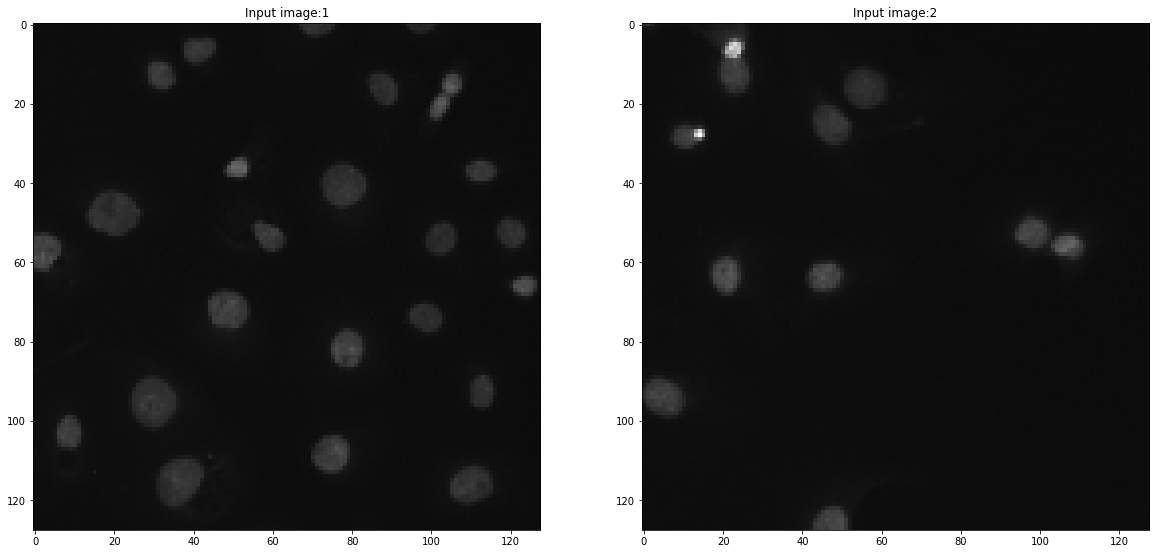

In [15]:
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = x.shape[0]-1

i = 0
while i <= rows:
    img= x[i]      #Since my arrays 1st location 0
    
    fig.add_subplot(rows, columns, i+1)                     #Here starting should be from i = 1 for 0 it will show an error
    plt.title('Input image:{}'.format(i+1))
    plt.imshow(img, cmap = plt.cm.bone)
    i = i + 1
plt.show()

### Corresponding Output data batch:

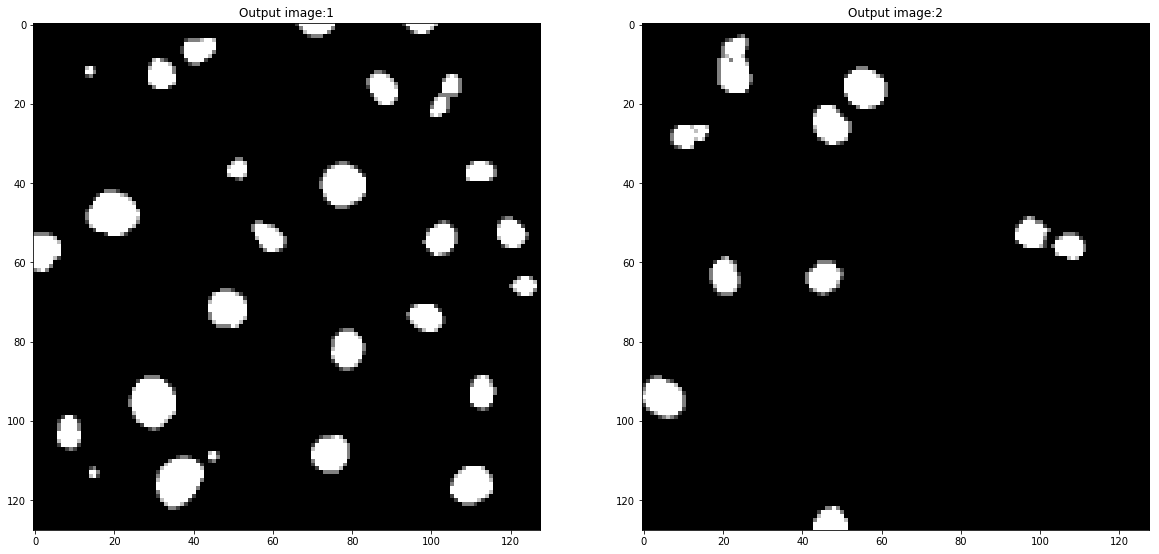

In [19]:
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = y.shape[0]-1
i = 0
while i <= rows:
    img= y[i]      #Since my arrays 1st location 0
    fig.add_subplot(rows, columns, i+1)                     #Here starting should be from i = 1 for 0 it will show an error
    plt.title('Output image:{}'.format(i+1))
    plt.imshow(np.reshape(img, (image_size, image_size)), cmap="gray")
    i = i + 1
plt.show()

### One sample input and corresponding combined segmented output image in the batch

r is 0


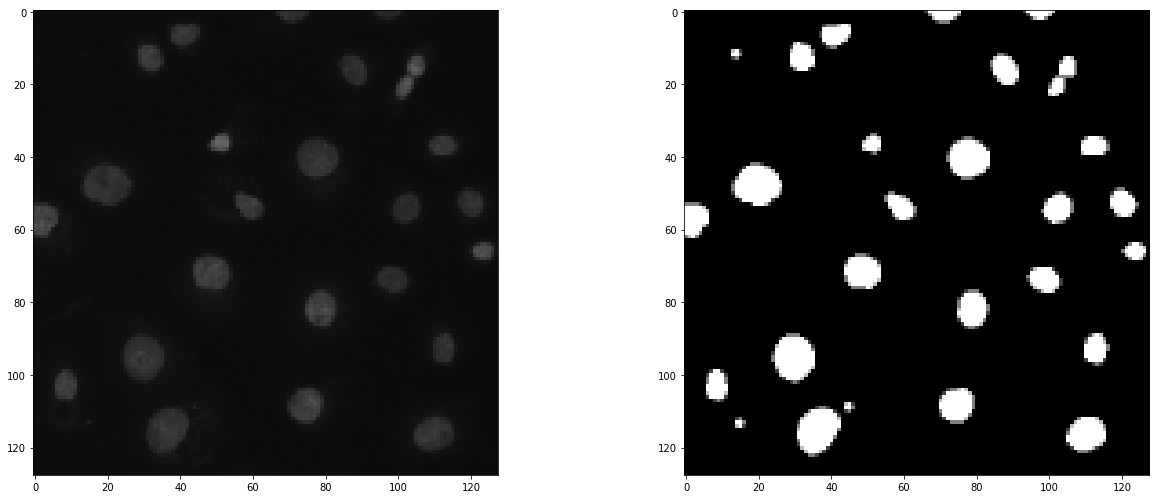

In [20]:
r = random.randint(0, len(x)-1)
print('r is', r)
fig = plt.figure()
fig=plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

### Note that: 
input is black and white as well as in colour. Some input images are blackwhite and some are black and white

# Different Convolutional Blocks

#### Downsampling Path: 
The contracting path follows the typical architecture of a convolutional network. It consists of:
1. the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.
2. At each downsampling step we double the number of feature channels.

In [21]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    #the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c) #2x2 max pooling operation with stride 2 for downsampling
    return c, p

#### Upsampling path:
- Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. 
- The cropping is necessary due to the loss of border pixels in every convolution. 
- Slip connection: The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connections provide local information to global information while upsampling.

In [22]:
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [23]:
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# UNet Model

In [24]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    #### Final Layer:
    #At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. 
    #In total the network has 23 convolutional layers.

    model = keras.models.Model(inputs, outputs)
    return model

In [27]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) # Compile model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

### Error or Loss Function: A loss function (or objective function, or optimization score function) is one of the two parameters required to compile a model:
- Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical:

from keras.utils import to_categorical

categorical_labels = to_categorical(int_labels, num_classes=None)
When using the sparse_categorical_crossentropy loss, your targets should be integer targets. If you have categorical targets, you should use categorical_crossentropy.

# Training the model

#traying out simple keras model execution
train_steps = len(x)//batch_size
print('training steps are:', train_steps)
model.fit_generator(x, y, epochs=epochs)

In [28]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print('Validation dataset names:', len(valid_ids))
print('training dataset names:', len(train_ids))
print(batch_size, train_steps, valid_steps)
#if btach_size is 2, training dataset size is 6 (hence 3 batches each having: 2 imgs), 
#validation dataset size is 2 (hence 1 batch 2 imgs). To train a model on training dataset 
#it will take 3 steps and for validation it will take one step

Validation dataset names: 6
training dataset names: 24
2 12 3


In [ ]:
%time model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,epochs=epochs)

### For training we will use fit_generator function in keras
fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

Trains the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).

The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

The use of keras.utils.Sequence guarantees the ordering and guarantees the single use of every input per epoch when using use_multiprocessing=True.

In [ ]:
#Testing: Trying to print output of 1st layer

f = [16, 32, 64, 128, 256]  # this is the size of the pixels. Here bottleneck is 16

inputs = keras.layers.Input((image_size, image_size, 3)) #defined input layer
print(inputs.shape)
p0 = inputs
c1, p1 = down_block(p0, f[0]) #128 -> 64

#ann = keras.Sequential()
outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(p1)
#ann.add(outputs)

outputs.get_shape()

# Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)  # we will take one batch of validation dataset 
result = model.predict(x)

#result = result > 0.5

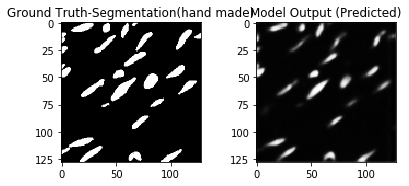

In [32]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")


ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

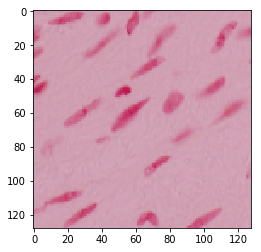

In [33]:
plt.imshow(x[0]) # above results for this input image

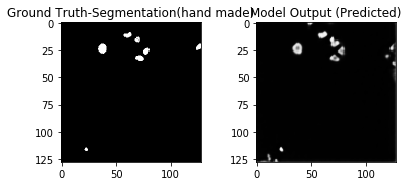

In [34]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [35]:
## Zomming in the above outputs

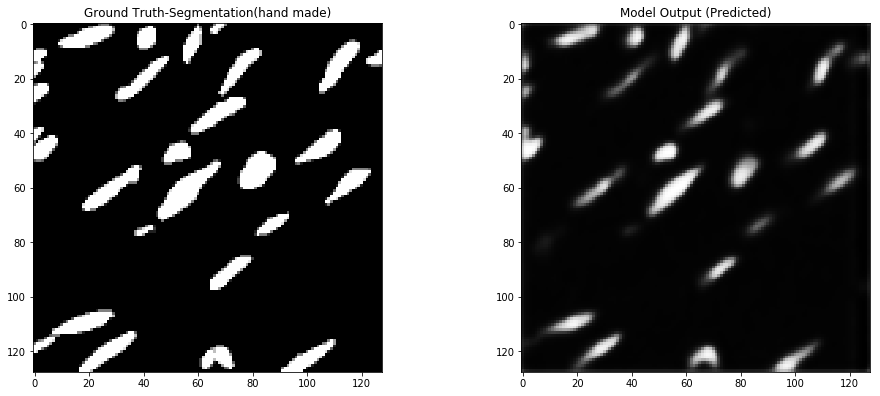

In [36]:
fig = plt.figure()
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")


ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

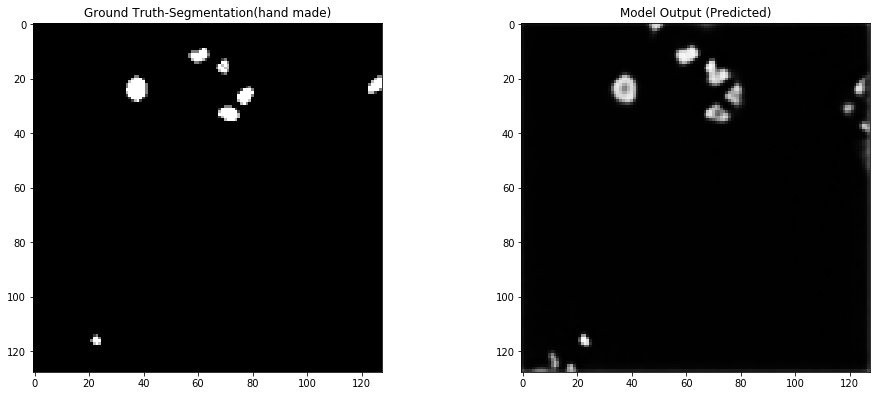

In [37]:
fig = plt.figure()
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")